In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=28

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Food",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 3000 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Burger', 'Chocolate_Cake', 'Pizza']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 2 2 0 2 0 2 2 0 0 2 0 2 2 2 0 2 2 1 1 1 2 2 2 1 0 2 2 1 0 1]


In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy()) #representing image in matrix format

[[[ 32.  29.  38.]
  [ 33.  30.  39.]
  [ 32.  31.  39.]
  ...
  [ 93.  98. 128.]
  [ 45.  52.  81.]
  [ 44.  51.  80.]]

 [[ 34.  31.  40.]
  [ 36.  33.  42.]
  [ 35.  34.  42.]
  ...
  [ 44.  51.  79.]
  [ 37.  47.  74.]
  [ 50.  60.  87.]]

 [[ 32.  29.  38.]
  [ 33.  30.  39.]
  [ 34.  31.  40.]
  ...
  [ 39.  51.  75.]
  [ 42.  57.  80.]
  [ 46.  62.  85.]]

 ...

 [[154. 186. 211.]
  [156. 188. 213.]
  [159. 190. 218.]
  ...
  [225. 249. 255.]
  [225. 247. 255.]
  [224. 246. 255.]]

 [[156. 188. 213.]
  [157. 189. 214.]
  [159. 191. 216.]
  ...
  [216. 240. 252.]
  [216. 238. 251.]
  [216. 238. 251.]]

 [[156. 188. 213.]
  [156. 188. 213.]
  [157. 189. 214.]
  ...
  [209. 233. 245.]
  [210. 232. 245.]
  [210. 232. 245.]]]


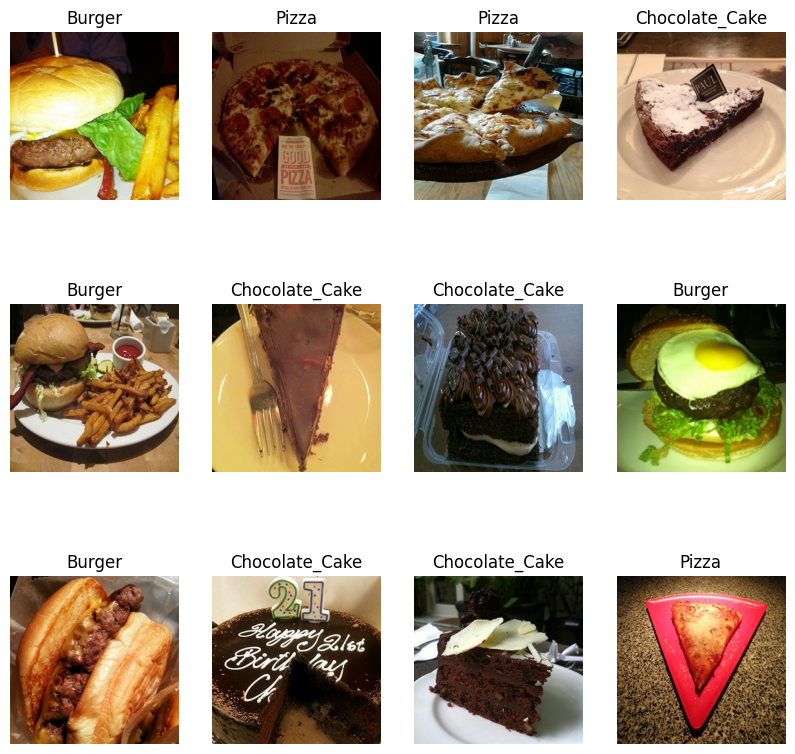

In [7]:
plt.figure(figsize=(10,10)) #adjusting dimension
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

94

In [9]:
# dataset will be splitted as follows
# 80% -> training
# 10% -> validation
# 10% -> test

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [12]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

75
9
10


In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [15]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/28
75/75 [==============================] - 101s 1s/step - loss: 0.9823 - accuracy: 0.5171 - val_loss: 0.8831 - val_accuracy: 0.5347
Epoch 2/28
75/75 [==============================] - 87s 1s/step - loss: 0.8464 - accuracy: 0.6058 - val_loss: 0.7998 - val_accuracy: 0.6701
Epoch 3/28
75/75 [==============================] - 79s 1s/step - loss: 0.7732 - accuracy: 0.6718 - val_loss: 0.6549 - val_accuracy: 0.7083
Epoch 4/28
75/75 [==============================] - 85s 1s/step - loss: 0.7287 - accuracy: 0.6919 - val_loss: 0.7378 - val_accuracy: 0.6701
Epoch 5/28
75/75 [==============================] - 80s 1s/step - loss: 0.6433 - accuracy: 0.7341 - val_loss: 0.5629 - val_accuracy: 0.7569
Epoch 6/28
75/75 [==============================] - 82s 1s/step - loss: 0.6167 - accuracy: 0.7508 - val_loss: 0.6806 - val_accuracy: 0.7188
Epoch 7/28
75/75 [==============================] - 81s 1s/step - loss: 0.5511 - accuracy: 0.7826 - val_loss: 0.5817 - val_accuracy: 0.7917
Epoch 8/28
75/75 [=

In [20]:
scores=model.evaluate(test_ds)

10/10 [==============================] - 6s 242ms/step - loss: 0.3534 - accuracy: 0.9438


In [21]:
scores

[0.35337308049201965, 0.9437500238418579]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 28, 'steps': 75}

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

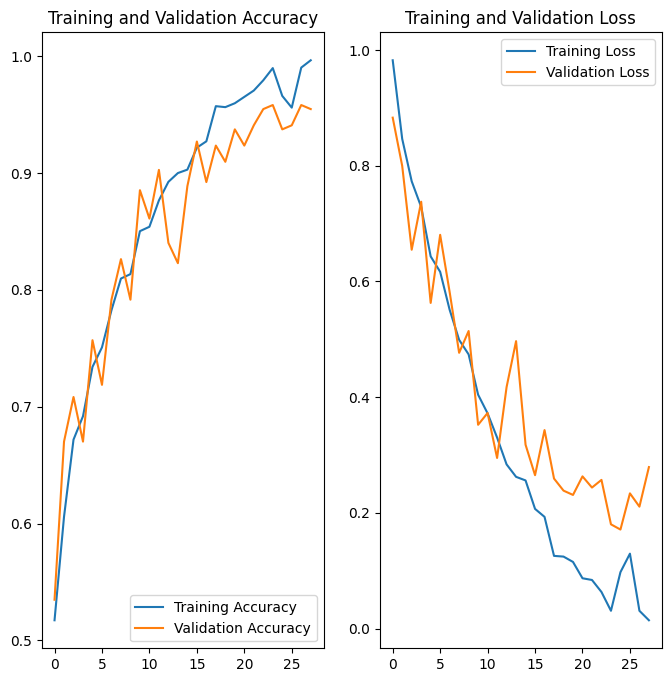

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
import numpy as np

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

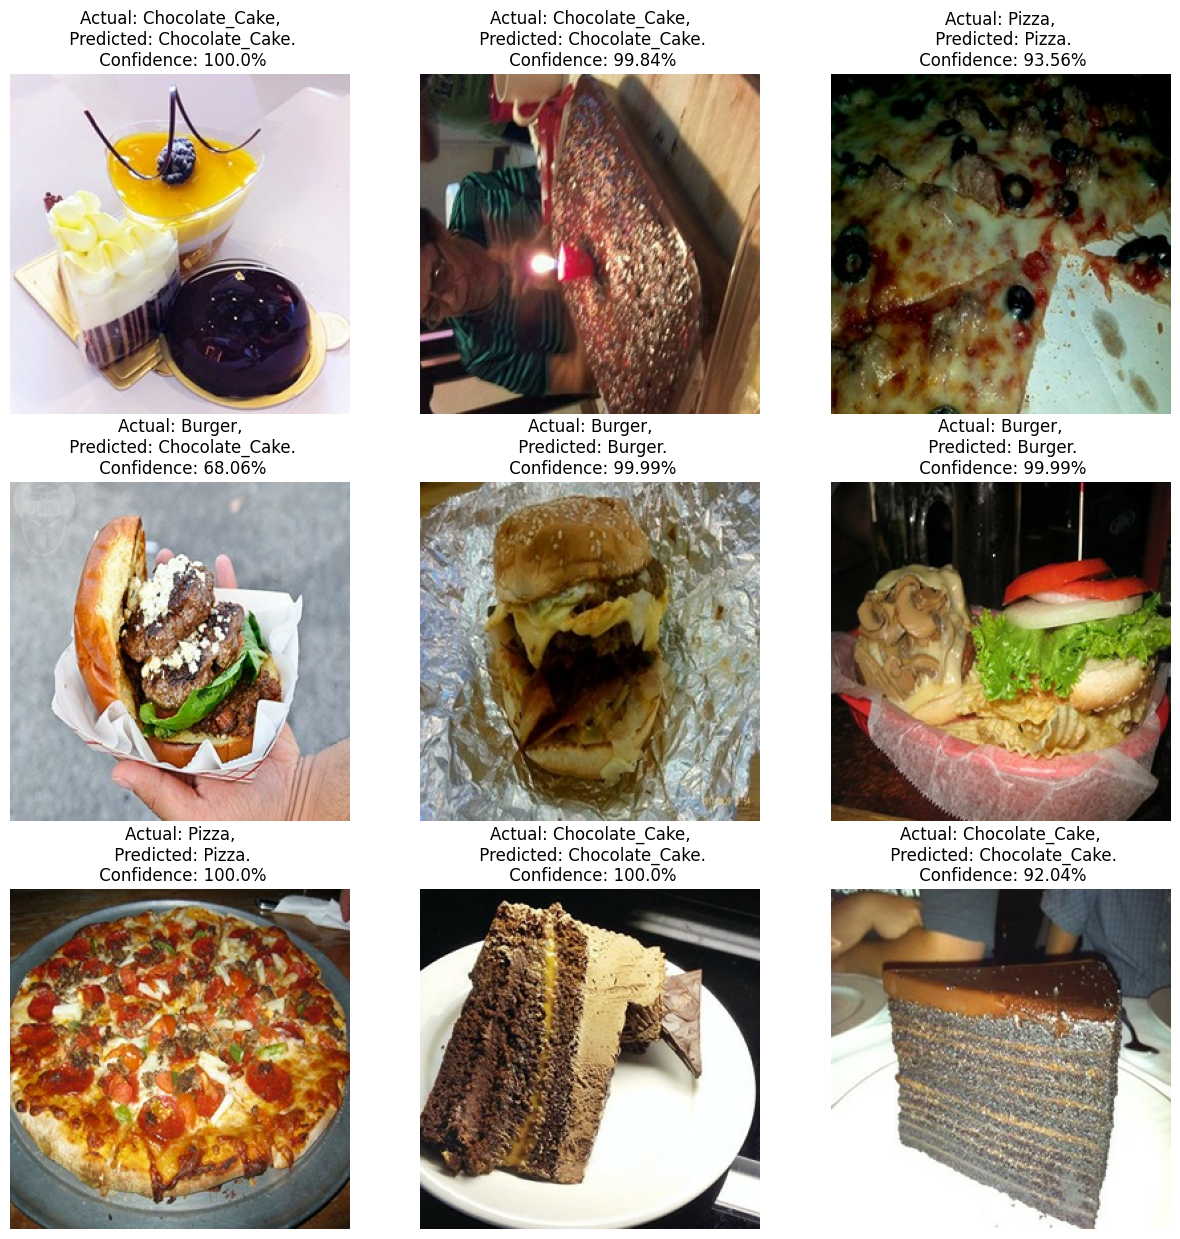

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
model

In [30]:
TF_LITE_MODEL_FILE_NAME="tf_lite_model.tflite"

In [31]:
tf_lite_converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\SAHILG~1\AppData\Local\Temp\tmpgh_id2xm\assets


In [32]:
tflite_model_name=TF_LITE_MODEL_FILE_NAME
open(tflite_model_name,"wb").write(tflite_model)

741064